# CNN

In [118]:
# build architecture 

import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class AttentionUNetRegressor(nn.Module):
    def __init__(self, in_channels=1, features=[32, 64, 128]):
        super().__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, features[0])
        self.enc2 = self.conv_block(features[0], features[1])
        self.enc3 = self.conv_block(features[1], features[2])

        # Decoder
        self.up2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.att2 = AttentionGate(F_g=features[1], F_l=features[1], F_int=features[1] // 2)
        self.dec2 = self.conv_block(features[2], features[1])

        self.up1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.att1 = AttentionGate(F_g=features[0], F_l=features[0], F_int=features[0] // 2)
        self.dec1 = self.conv_block(features[1], features[0])

        self.pool = nn.MaxPool2d(2)
        self.out = nn.Sequential(

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(features[0], 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
    )


    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Decoder
        d2 = self.up2(e3)
        e2_att = self.att2(g=d2, x=e2)
        d2 = self.dec2(torch.cat([d2, e2_att], dim=1))

        d1 = self.up1(d2)
        e1_att = self.att1(g=d1, x=e1)
        d1 = self.dec1(torch.cat([d1, e1_att], dim=1))

        return self.out(d1).squeeze(1)


In [50]:
# subject split 


# subject split

from torch.utils.data import Dataset, Subset, DataLoader
import torch
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

class FC3DVolumeDataset(Dataset):
    def __init__(self, fc_dir, label_dir, target_column='mean_scaled_anxiety'):
        self.samples = []
        self.targets = []
        self.subject_ids = []

        file_list = sorted([f for f in os.listdir(fc_dir) if f.endswith('_fc.npy')])
        for fname in file_list:
            subj_id = fname.replace('_fc.npy', '')
            label_path = os.path.join(label_dir, f"{subj_id}_labels.csv")
            if not os.path.exists(label_path):
                print(f"⚠️ Skipping {subj_id} (no label file)")
                continue

            df = pd.read_csv(label_path)
            if target_column not in df.columns:
                print(f"⚠️ Skipping {subj_id} (target column missing)")
                continue

            fc_path = os.path.join(fc_dir, fname)
            fc_array = np.load(fc_path)  # shape: (91, 100, 100)
            labels = df[target_column].values  # shape: (91,)

            if fc_array.shape[0] != len(labels):
                print(f"⚠️ Skipping {subj_id} (window/label mismatch)")
                continue

            for fc_window, label in zip(fc_array, labels):
                self.samples.append(fc_window[None, ...])  # (1, 100, 100)
                self.targets.append(label)
                self.subject_ids.append(subj_id)

            print(f"✅ Loaded {subj_id}: {len(labels)} windows")

        self.samples = torch.tensor(np.array(self.samples), dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.targets[idx]

# === Load and split ===

dataset = FC3DVolumeDataset(fc_dir='fc_matrices', label_dir='fc_matrices')

# Extract unique subject IDs
unique_subjects = list(set(dataset.subject_ids))
np.random.shuffle(unique_subjects)

# 80/20 subject split
train_subjects = set(unique_subjects[:int(0.8 * len(unique_subjects))])
test_subjects = set(unique_subjects[int(0.8 * len(unique_subjects)):])

# Get indices of samples (windows) by subject
train_indices = [i for i, sid in enumerate(dataset.subject_ids) if sid in train_subjects]
test_indices = [i for i, sid in enumerate(dataset.subject_ids) if sid in test_subjects]

# === Normalize targets to [-1, 1] ===

# Extract targets
train_targets = torch.stack([dataset[i][1] for i in train_indices]).numpy().reshape(-1, 1)
test_targets = torch.stack([dataset[i][1] for i in test_indices]).numpy().reshape(-1, 1)

# Fit scaler on train, transform both
scaler = MinMaxScaler(feature_range=(-1, 1))
train_targets_scaled = scaler.fit_transform(train_targets)
test_targets_scaled = scaler.transform(test_targets)

# Replace in dataset
for i, idx in enumerate(train_indices):
    dataset.targets[idx] = torch.tensor(train_targets_scaled[i].item(), dtype=torch.float32)
for i, idx in enumerate(test_indices):
    dataset.targets[idx] = torch.tensor(test_targets_scaled[i].item(), dtype=torch.float32)

# Save scaler for later inverse-transform
joblib.dump(scaler, 'label_scaler.save')

# === Build subsets and loaders ===

train_ds = Subset(dataset, train_indices)
test_ds = Subset(dataset, test_indices)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=4)


✅ Loaded sub-S01: 91 windows
✅ Loaded sub-S02: 91 windows
✅ Loaded sub-S03: 91 windows
✅ Loaded sub-S04: 91 windows
✅ Loaded sub-S05: 91 windows
✅ Loaded sub-S06: 91 windows
✅ Loaded sub-S07: 91 windows
✅ Loaded sub-S08: 91 windows
✅ Loaded sub-S09: 91 windows
✅ Loaded sub-S10: 91 windows
✅ Loaded sub-S11: 91 windows
✅ Loaded sub-S13: 91 windows
✅ Loaded sub-S14: 91 windows
✅ Loaded sub-S15: 91 windows
✅ Loaded sub-S16: 91 windows
✅ Loaded sub-S17: 91 windows
✅ Loaded sub-S19: 91 windows
✅ Loaded sub-S20: 91 windows
✅ Loaded sub-S21: 91 windows
✅ Loaded sub-S22: 91 windows
✅ Loaded sub-S23: 91 windows
✅ Loaded sub-S24: 91 windows
✅ Loaded sub-S25: 91 windows
✅ Loaded sub-S26: 91 windows
✅ Loaded sub-S27: 91 windows
✅ Loaded sub-S28: 91 windows
✅ Loaded sub-S29: 91 windows
✅ Loaded sub-S30: 91 windows
✅ Loaded sub-S31: 91 windows
✅ Loaded sub-S32: 91 windows


In [52]:
class BinWeightedHuberLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.huber = nn.SmoothL1Loss(reduction='none')

    def forward(self, predictions, targets, bin_labels):
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        weights = torch.tensor(
            [1.0 if b == "low" else 2.0 if b == "medium" else 3.0 for b in bin_labels],
            dtype=torch.float32,
            device=predictions.device
        )

        loss = self.huber(predictions, targets)
        weighted_loss = (loss * weights).mean()
        return weighted_loss


In [53]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AttentionUNetRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = torch.nn.SmoothL1Loss()


def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader, desc="Training", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
    return total_loss / len(loader.dataset)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss += loss_fn(pred, y).item() * len(y)
            preds.extend(pred.cpu().numpy())
            targets.extend(y.cpu().numpy())
    
    mse = mean_squared_error(targets, preds)
    mae = mean_absolute_error(targets, preds)
    r2 = r2_score(targets, preds)

    print(f"📊 Test MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
    return total_loss / len(loader.dataset), preds, targets


# Training loop
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_dl, optimizer, loss_fn)
    test_loss, _, _ = evaluate(model, test_dl, loss_fn)
    print(f"Epoch {epoch:02d}: Train Loss = {train_loss:.4f} | Test Loss = {test_loss:.4f}")


KeyboardInterrupt: 

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(preds, targets, title="Predicted vs. Actual Anxiety"):
    plt.figure(figsize=(6, 6))
    plt.scatter(targets, preds, alpha=0.6, edgecolors='k')
    plt.plot([0, 1], [0, 1], 'r--')  # reference line: perfect prediction
    plt.xlabel("Actual Anxiety")
    plt.ylabel("Predicted Anxiety")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


📊 Test MSE: 0.1681 | MAE: 0.3180 | R²: 0.4150


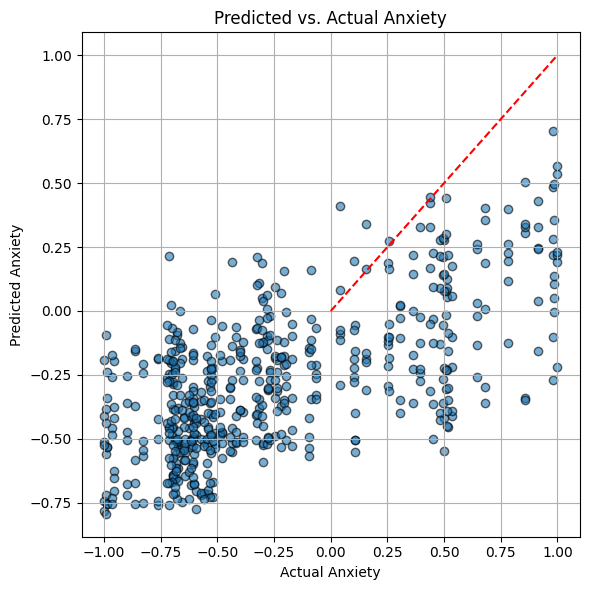

In [29]:
test_loss, preds, targets = evaluate(model, test_dl, loss_fn)
plot_predictions(preds, targets)


In [30]:
def plot_predictions_by_bin(preds, targets):
    preds = np.array(preds)
    targets = np.array(targets)
    bins = pd.cut(targets, bins=[0, 0.33, 0.66, 1], labels=["Low", "Medium", "High"])

    plt.figure(figsize=(6,6))
    for label, color in zip(["Low", "Medium", "High"], ["green", "blue", "red"]):
        idx = (bins == label)
        plt.scatter(targets[idx], preds[idx], alpha=0.5, label=label, color=color, edgecolors='k')

    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel("Actual Anxiety")
    plt.ylabel("Predicted Anxiety")
    plt.title("Predicted vs. Actual Anxiety (Colored by Bin)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


📊 Test MSE: 0.1681 | MAE: 0.3180 | R²: 0.4150


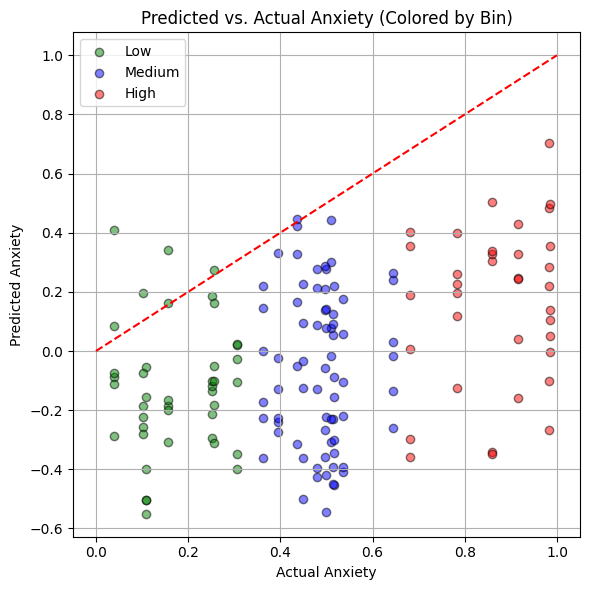

In [31]:
test_loss, preds, targets = evaluate(model, test_dl, loss_fn)
plot_predictions_by_bin(preds, targets)


it is learning low well, medium not enough, and high way too much. lets try some weighting to see if we can fix things a bit 

In [119]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import os
import pandas as pd

# Your dataset class
class FC3DVolumeDataset(Dataset):
    def __init__(self, fc_dir, label_dir, target_column='mean_scaled_anxiety'):
        self.samples = []
        self.targets = []
        self.subject_ids = []
        self.bins = []

        file_list = sorted([f for f in os.listdir(fc_dir) if f.endswith('_fc.npy')])
        for fname in file_list:
            subj_id = fname.replace('_fc.npy', '')
            label_path = os.path.join(label_dir, f"{subj_id}_labels.csv")
            if not os.path.exists(label_path):
                continue

            df = pd.read_csv(label_path)
            if target_column not in df.columns:
                continue

            fc_path = os.path.join(fc_dir, fname)
            fc_array = np.load(fc_path)
            labels = df[target_column].values

            if fc_array.shape[0] != len(labels):
                continue

            bin_labels = pd.cut(labels, bins=[0, 0.33, 0.66, 1], labels=["low", "medium", "high"])

            for fc_window, label, bin_label in zip(fc_array, labels, bin_labels):
                self.samples.append(fc_window[None, ...])
                self.targets.append(label)
                self.subject_ids.append(subj_id)
                self.bins.append(str(bin_label))

        self.samples = torch.tensor(np.array(self.samples), dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.targets[idx], self.bins[idx]

# Custom subset that preserves all outputs
class WrappedSubset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

# --- 🔧 DATA SPLIT BY SUBJECT ---
# Instantiate the dataset
dataset = FC3DVolumeDataset(fc_dir='fc_matrices', label_dir='fc_matrices')

# Get subject-level split
unique_subjects = sorted(set(dataset.subject_ids))
train_subj, test_subj = train_test_split(unique_subjects, test_size=0.2, random_state=42)

train_indices = [i for i, s in enumerate(dataset.subject_ids) if s in train_subj]
test_indices = [i for i, s in enumerate(dataset.subject_ids) if s in test_subj]

# Wrapped subset to keep (x, y, bin_label)
train_ds = WrappedSubset(dataset, train_indices)
test_ds = WrappedSubset(dataset, test_indices)

# Dataloaders
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=4)


In [123]:
import torch.nn as nn

class BinWeightedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, predictions, targets, bin_labels):
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        weights = torch.tensor(
            [4.0 if b == "low" else 1.0 if b == "medium" else 5.0 for b in bin_labels],
            dtype=torch.float32,
            device=predictions.device
        )

        loss = self.mse(predictions, targets)
        weighted_loss = (loss * weights).mean()
        return weighted_loss



In [124]:
from tqdm import tqdm
import torch.nn.functional as F

loss_fn = BinWeightedMSELoss()  # ✅ Use the class instance!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AttentionUNetRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

def train(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for x, y, bin_labels in tqdm(loader, desc="Training"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        preds = torch.clamp(preds, min=0.0, max=1.0) 
        loss = loss_fn(preds, y, bin_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
    return total_loss / len(loader.dataset)

def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    preds_all = []
    targets_all = []
    with torch.no_grad():
        for x, y, bin_labels in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = loss_fn(preds, y, bin_labels)
            total_loss += loss.item() * len(y)
            preds_all.extend(preds.cpu().numpy())
            targets_all.extend(y.cpu().numpy())
    preds_all = np.array(preds_all)
    targets_all = np.array(targets_all)
    mae = np.mean(np.abs(preds_all - targets_all))
    mse = np.mean((preds_all - targets_all) ** 2)
    r2 = 1 - np.sum((preds_all - targets_all) ** 2) / np.sum((targets_all - targets_all.mean()) ** 2)
    print(f"📊 Test MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
    return total_loss / len(loader.dataset), preds_all, targets_all

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_dl, optimizer, loss_fn, device)
    test_loss, _, _ = evaluate(model, test_dl, loss_fn, device)
    print(f"Epoch {epoch:02d}: Train Loss = {train_loss:.4f} | Test Loss = {test_loss:.4f}")


Training: 100%|██████████| 546/546 [00:03<00:00, 144.38it/s]


📊 Test MSE: 0.0476 | MAE: 0.1675 | R²: -0.1296
Epoch 01: Train Loss = 0.1659 | Test Loss = 0.1574


Training: 100%|██████████| 546/546 [00:03<00:00, 157.90it/s]


📊 Test MSE: 0.0430 | MAE: 0.1621 | R²: -0.0220
Epoch 02: Train Loss = 0.1401 | Test Loss = 0.1439


Training: 100%|██████████| 546/546 [00:03<00:00, 155.17it/s]


📊 Test MSE: 0.0394 | MAE: 0.1636 | R²: 0.0637
Epoch 03: Train Loss = 0.1264 | Test Loss = 0.1335


Training: 100%|██████████| 546/546 [00:03<00:00, 157.94it/s]


📊 Test MSE: 0.0412 | MAE: 0.1593 | R²: 0.0204
Epoch 04: Train Loss = 0.0897 | Test Loss = 0.1207


Training: 100%|██████████| 546/546 [00:03<00:00, 158.75it/s]


📊 Test MSE: 0.0399 | MAE: 0.1573 | R²: 0.0518
Epoch 05: Train Loss = 0.0523 | Test Loss = 0.1307


Training: 100%|██████████| 546/546 [00:03<00:00, 157.28it/s]


📊 Test MSE: 0.0427 | MAE: 0.1639 | R²: -0.0136
Epoch 06: Train Loss = 0.0373 | Test Loss = 0.1469


Training: 100%|██████████| 546/546 [00:03<00:00, 154.27it/s]


📊 Test MSE: 0.0341 | MAE: 0.1413 | R²: 0.1900
Epoch 07: Train Loss = 0.0277 | Test Loss = 0.1001


Training: 100%|██████████| 546/546 [00:03<00:00, 155.48it/s]


📊 Test MSE: 0.0488 | MAE: 0.1785 | R²: -0.1587
Epoch 08: Train Loss = 0.0312 | Test Loss = 0.1721


Training: 100%|██████████| 546/546 [00:03<00:00, 156.97it/s]


📊 Test MSE: 0.0334 | MAE: 0.1427 | R²: 0.2057
Epoch 09: Train Loss = 0.0233 | Test Loss = 0.0882


Training: 100%|██████████| 546/546 [00:03<00:00, 154.81it/s]


📊 Test MSE: 0.0426 | MAE: 0.1589 | R²: -0.0120
Epoch 10: Train Loss = 0.0229 | Test Loss = 0.1452


Training: 100%|██████████| 546/546 [00:03<00:00, 155.24it/s]


📊 Test MSE: 0.0398 | MAE: 0.1521 | R²: 0.0554
Epoch 11: Train Loss = 0.0179 | Test Loss = 0.0977


Training: 100%|██████████| 546/546 [00:03<00:00, 155.42it/s]


📊 Test MSE: 0.0413 | MAE: 0.1507 | R²: 0.0191
Epoch 12: Train Loss = 0.0175 | Test Loss = 0.1038


Training: 100%|██████████| 546/546 [00:03<00:00, 157.26it/s]


📊 Test MSE: 0.0359 | MAE: 0.1503 | R²: 0.1469
Epoch 13: Train Loss = 0.0145 | Test Loss = 0.1129


Training: 100%|██████████| 546/546 [00:03<00:00, 156.09it/s]


📊 Test MSE: 0.0305 | MAE: 0.1357 | R²: 0.2745
Epoch 14: Train Loss = 0.0117 | Test Loss = 0.0821


Training: 100%|██████████| 546/546 [00:03<00:00, 156.89it/s]


📊 Test MSE: 0.0358 | MAE: 0.1448 | R²: 0.1500
Epoch 15: Train Loss = 0.0102 | Test Loss = 0.0964


Training: 100%|██████████| 546/546 [00:03<00:00, 157.94it/s]


📊 Test MSE: 0.0304 | MAE: 0.1330 | R²: 0.2784
Epoch 16: Train Loss = 0.0101 | Test Loss = 0.0858


Training: 100%|██████████| 546/546 [00:03<00:00, 153.31it/s]


📊 Test MSE: 0.0304 | MAE: 0.1373 | R²: 0.2775
Epoch 17: Train Loss = 0.0075 | Test Loss = 0.0999


Training: 100%|██████████| 546/546 [00:03<00:00, 152.27it/s]


📊 Test MSE: 0.0299 | MAE: 0.1342 | R²: 0.2909
Epoch 18: Train Loss = 0.0069 | Test Loss = 0.0833


Training: 100%|██████████| 546/546 [00:03<00:00, 156.83it/s]


📊 Test MSE: 0.0326 | MAE: 0.1453 | R²: 0.2262
Epoch 19: Train Loss = 0.0083 | Test Loss = 0.1076


Training: 100%|██████████| 546/546 [00:03<00:00, 155.75it/s]


📊 Test MSE: 0.0295 | MAE: 0.1359 | R²: 0.2994
Epoch 20: Train Loss = 0.0063 | Test Loss = 0.0902


📊 Test MSE: 0.0295 | MAE: 0.1359 | R²: 0.2994


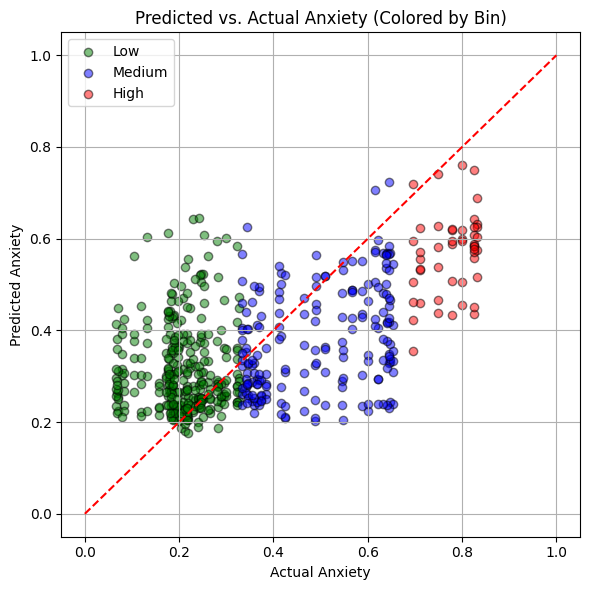

In [125]:
import matplotlib.pyplot as plt
test_loss, preds, targets = evaluate(model, test_dl, loss_fn, device)
plot_predictions_by_bin(preds, targets)


In [90]:
class FocalBinMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, predictions, targets, bin_labels):
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        errors = torch.abs(predictions - targets).detach()

        base_weights = torch.tensor([
            3.0 if b == "low" else 4.0 if b == "medium" else 7.0
            for b in bin_labels
        ], dtype=torch.float32, device=predictions.device)

        scaled_weights = base_weights * errors  # more error → more penalty
        loss = self.mse(predictions, targets) * scaled_weights
        return loss.mean()
